In [106]:
import praw
from praw.models import MoreComments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import stylecloud
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

In [2]:
reddit = praw.Reddit(client_id='Uqa0qPvYrRATm6WB2yy6vw', client_secret='ExLLWnJZrEJ5XrSdU9GQ074YOoOg5A', user_agent='sentiment')

In [3]:
def get_whole_thread(submission):
    # d = {}
    comments = []
    for top_level_comment in submission.comments:
        # print("COMMENT:")
        # print(top_level_comment.body)
        # d[top_level_comment.body] = []
        comments.append(top_level_comment.body)
        replies = []
        replies.extend(top_level_comment.replies)
        while replies:
            reply = replies.pop(0)
            if isinstance(reply, MoreComments):
                continue
            # print("    SUBCOMMENT:")
            # print(reply.body)
            # d[top_level_comment.body].append(reply.body)
            comments.append(reply.body)
            # print("________")
            replies = list(reply.replies) + replies
    return comments

In [4]:
subreddit = reddit.subreddit("SGExams")
cnt = 0
posts = []
print("start")
for submission in subreddit.search("smu cs"):
    post = []
    post.append(submission.title)
    post.append(submission.selftext)
    comments = get_whole_thread(submission)
    post.append(comments)
    posts.append(post)

print('end')

start
end


In [107]:
df = pd.DataFrame(posts,columns=['title', 'body', 'comments'])
# print(df)
# df.to_csv("reddit_sg_exams.csv", sep='\t')
df.head()

,title,body,comments
0,[uni] SMU CS discovery day,got an acceptance email tdy for SMU CS saying ...,"[wat ur rp?, 82.5, I was equally as surprised ..."
1,[Uni] SMU cs or NUS cs,"\n\nHello, i’m looking to apply for my uni cou...","[Tbh and no offense to OP, I keep seeing these..."
2,[uni] SMU CS vs IS,"hi there, i just wanted to ask any students in...","[>hey ! current smu cs student, imo the resour..."
3,[UNI] How is SMU CS like?,Got rejected by NTU and NUS... I have attended...,[I would like to know too I’m thinking of join...
4,[Uni] SMU CS vs NTU CS,"Hey, anyone able to shed some light on SMU Com...",[Im unable to comment on SMU CS but I'm able t...


In [108]:
#Show the titles that contain NTU, CS, SMU and not transfer (transfer thread not relevant to outreach)
only_ntu = df[df['title'].str.contains('NTU')]
qn_content =""
for line in only_ntu['title']:
    if 'ntu' in line.lower() and 'cs' in line.lower() and 'smu' in line.lower() and 'transfer' not in line.lower(): 
        qn_content += line.lower() + ' '    
        print(line)

[Uni] SMU CS vs NTU CS
[A levels] NTU CS /NTU CE and SMU IS/SMU CS
[Uni] NTU business and computing and SMU CS+BIZ
[Uni] SMU CS or NTU CE
[A levels] SMU IS vs SIT CS vs NTU CE vs SUTD ISTD
[Uni] What are the job prospects of a biz degree? Should I study biz at NUS or CS at NTU/SMU?
[Uni] I need some help in choosing uni course. NTU or SMU for CS? seniors please give me your input!!


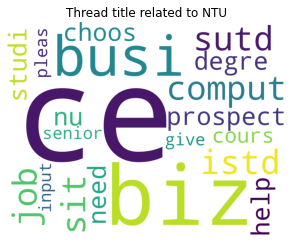

In [109]:
#Cloud word for titles that contain NTU, SMU CS
stop_words = stopwords.words('english')
stop_words.extend(['ntu', 'uni', 'smu', 'cs', 'vs', 'level', 'levels'])

qn_content = ''
for line in df['title']:
    if 'ntu' in line.lower() and 'cs' in line.lower() and 'smu' in line.lower() and 'transfer' not in line.lower():
        qn_content += line.lower() + ' '    
        #print(line)

# Tokenize Words
tokenizer = RegexpTokenizer(r'\w+')
words_content = tokenizer.tokenize(qn_content)  # All answers for that question into words

# Remove stop words
words_filtered = []
for w in words_content:
    if w not in stop_words:
        words_filtered.append(w)

# Porter Stemmer
porter_stemmer = PorterStemmer()

words_stemmed = []
for w in words_filtered:
    words_stemmed.append(porter_stemmer.stem(w))

# WordCloud
words_joined = " ".join([w for w in words_stemmed])

# Create a word cloud
my_wordcloud = WordCloud(background_color='white',
                     width=1800,
                     height=1400).generate(words_joined)

plt.imshow(my_wordcloud)
plt.axis('off')
plt.title('Thread title related to NTU')
plt.show()

In [110]:
only_ntu = df[df['title'].str.contains('NTU')]
only_ntu.head()

,title,body,comments
4,[Uni] SMU CS vs NTU CS,"Hey, anyone able to shed some light on SMU Com...",[Im unable to comment on SMU CS but I'm able t...
5,[A levels] NTU CS /NTU CE and SMU IS/SMU CS,So I got 75rp and can't go to NTU/SMU CS so I ...,[Go to NTU CE or SIT UOG if you really want to...
12,[Uni] NTU business and computing and SMU CS+BIZ,Hi all would need some advice on these choices...,"[[deleted], I havent seen anyone below 80, I h..."
14,[Uni] SMU CS or NTU CE,I just received admissions from these two Univ...,"[[deleted], Care to explain?]"
19,[UNI] NUS CS VS NTU CN YANG SCHOLARS PROGRAMME...,Hi! I would like to know whether I should cho...,[go cnyang if you want to do research. If unsu...


In [111]:
# original stopwords
def original_stopwords():
    return stopwords.words('english')

In [112]:
def extract_text(df):
    for(columnName, columnData) in df.iteritems():
        qn_content = []
        for line in df[columnName]:
            if len(line.strip()) > 0: # Eliminates empty answers
                qn_content.append(line)
    return qn_content

In [113]:
# Helper Function for Tokenisation of text content, returns a list of word or words depending on ngrams defined
import string

def token_fn(sentence_list, n, stop_words_custom):
    output = []
    output2 = []
    for line in sentence_list:
        #remove punctuations
        new_string = line.translate(str.maketrans('', '', string.punctuation))
        new_string = new_string.replace('“', '')
        new_string = new_string.replace('”', '')
        
        x = new_string.split()
        
        for word in x:
            if word not in stop_words_custom:
                #print(word)
                output.append(word)

        sentence = ""
        for word in output:
            sentence += word + " "
        
        token = word_tokenize(sentence)
        gram = list(ngrams(token, n))

        if n == 1:
            for content in gram:
                for word in content:
                    output2.append(word)  
        else:
            for content in gram:
                link = ''
                for word in content:
                    link += word + '_'
                link = link[:-1]
                output2.append(link)
                
    return output2

def wc_fn(word_list, title, no_word_max):
    words_joined = " ".join([w for w in word_list])
    my_wordcloud = WordCloud(background_color='white', max_words = no_word_max, 
                             max_font_size = 1000,
                             width=3000,
                             height=2000).generate(words_joined)
    plt.imshow(my_wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

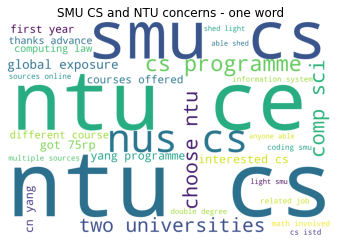

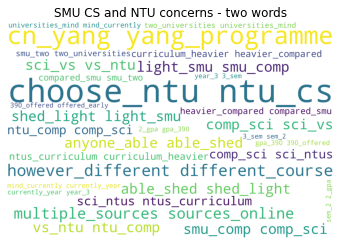

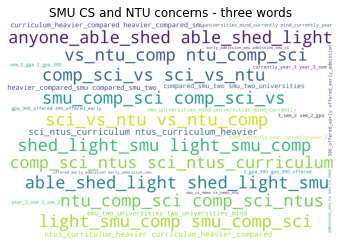

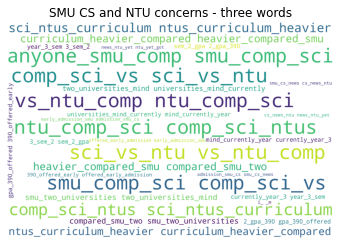

In [114]:
# # Top commmon body for SMU & NTU

smu_ntu_body = only_ntu.iloc[:, [1]]

sw = original_stopwords()
sw.extend(['exactly','x200b' , 'boil','nt', "n't",'rlly', 'u','hi', 'tat', 'much', 'sure', 'im', 'thank', 'really', "i'm", 'lol', 'bro', 'cmi', 
           'hahah' , 'one', 'well', 'hey', 'hey,' , 'also', 'would' , 'bat', 'right'])

sentences = []
for sentence in smu_ntu_body["body"]:
    #sentences = []
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower():
        sentences.append(sentence.lower())
    
    
single_word = token_fn(sentences, 1, sw)
wc_fn(single_word, 'SMU CS and NTU concerns - one word', 30)

double_word = token_fn(sentences, 2, sw)
wc_fn(double_word, 'SMU CS and NTU concerns - two words', 30)

triple_word = token_fn(sentences, 3, sw)
wc_fn(triple_word, 'SMU CS and NTU concerns - three words', 30)


sw.extend(['nt', "n't",'rlly', 'u','hi', 'tat', 'much', 'sure', 'im', 'thank', 'really', "i'm", 'lol', 'bro', 'cmi', 
           'hahah' , 'one', 'well', 'hey', 'hey,' , 'also', 'would' , 'bat', 'right' , 'shed' , 'light' , 'able'])

triple_word = token_fn(sentences, 3, sw)
wc_fn(triple_word, 'SMU CS and NTU concerns - three words', 30)

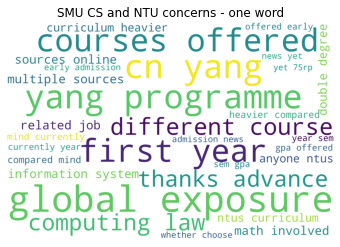

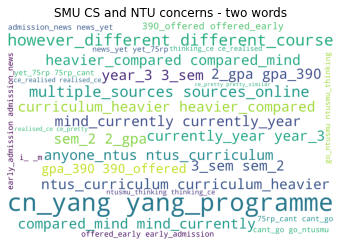

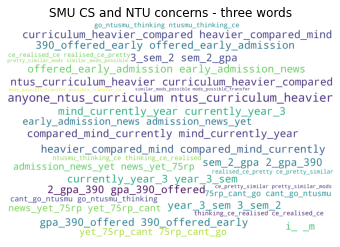

In [115]:
# # Top commmon body for SMU & NTU - deeper cleaning of words

smu_ntu_body = only_ntu.iloc[:, [1]]

sw = original_stopwords()
sw.extend(['shed', 'light', 'able', 'ntu', 'vs','got', 'universities','two','heard','cs','nus', 'smu', 'comp', 'sci','exactly','x200b' , 'boil','nt', "n't",'rlly', 'u','hi', 'tat', 'much', 'sure', 'im', 'thank', 'really', "i'm", 'lol', 'bro', 'cmi', 
           'hahah' , 'one', 'well', 'hey', 'hey,' , 'also', 'would' , 'bat', 'right'])

sentences = []
for sentence in smu_ntu_body["body"]:
    #sentences = []
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower():
        sentences.append(sentence.lower())
    
    
single_word = token_fn(sentences, 1, sw)
wc_fn(single_word, 'SMU CS and NTU concerns - one word', 30)

double_word = token_fn(sentences, 2, sw)
wc_fn(double_word, 'SMU CS and NTU concerns - two words', 30)

triple_word = token_fn(sentences, 3, sw)
wc_fn(triple_word, 'SMU CS and NTU concerns - three words', 30)

In [116]:
# #Total number of insights

smu_ntu_comments = only_ntu.iloc[:, [2]]

sentences = []
noOfThread = 0
totalComments = 0
for commentArray in smu_ntu_comments["comments"]:
    noOfThread += 1
    valueArray = 0
    for comment in commentArray:
        valueArray += 1
        totalComments += 1

print(noOfThread , ' no of Threads and' , totalComments , 'Comments for all Threads')
print('Average comments per thread: ' , totalComments/noOfThread)

15  no of Threads and 128 Comments for all Threads
Average comments per thread:  8.533333333333333


In [ ]:
## BIZ RELATED

In [131]:
#Finding for SMU, NTU, Biz
only_ntu = df[df['title'].str.contains('NTU')]
qn_content =""
for line in only_ntu['title']:
    if 'ntu' in line.lower() and 'biz' in line.lower() and 'smu' in line.lower() and 'transfer' not in line.lower(): 
        qn_content += line.lower() + ' '    
        print(line)

[Uni] NTU business and computing and SMU CS+BIZ
[Uni] What are the job prospects of a biz degree? Should I study biz at NUS or CS at NTU/SMU?
[Uni] Is DDP worth it? NTU DDP VS SMU BIZ


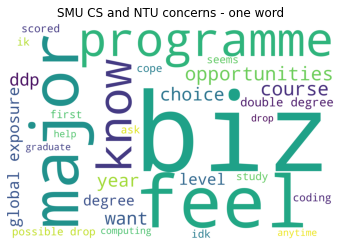

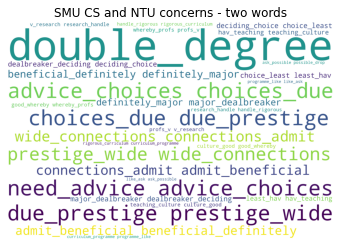

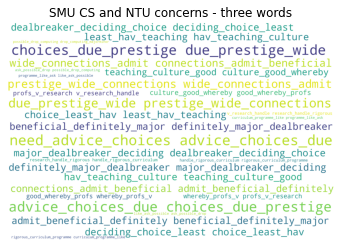

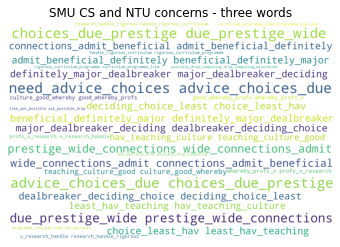

In [151]:
# # Top commmon body for SMU & NTU Biz

smu_ntu_body = only_ntu.iloc[:, [1]]
sentences = []

sw.extend(['dad', 'hinting'])

for sentence in smu_ntu_body["body"]:
    #sentences = []
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower() and 'biz' in sentence.lower():
        #print(sentence)
        sentences.append(sentence.lower())
        #print('--------------------------------')
    
    
single_word = token_fn(sentences, 1, sw)
wc_fn(single_word, 'SMU CS and NTU concerns - one word', 30)

double_word = token_fn(sentences, 2, sw)
wc_fn(double_word, 'SMU CS and NTU concerns - two words', 30)

triple_word = token_fn(sentences, 3, sw)
wc_fn(triple_word, 'SMU CS and NTU concerns - three words', 30)


sw.extend(['nt', "n't",'rlly', 'u','hi', 'tat', 'much', 'sure', 'im', 'thank', 'really', "i'm", 'lol', 'bro', 'cmi', 
           'hahah' , 'one', 'well', 'hey', 'hey,' , 'also', 'would' , 'bat', 'right' , 'shed' , 'light' , 'able'])

triple_word = token_fn(sentences, 3, sw)
wc_fn(triple_word, 'SMU CS and NTU concerns - three words', 30)

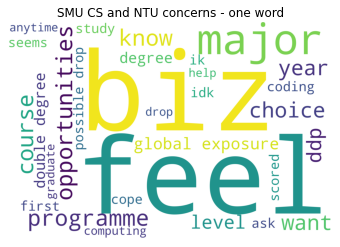

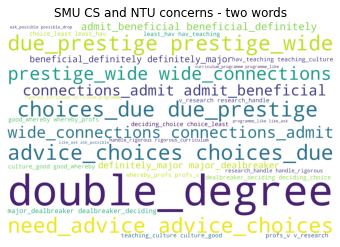

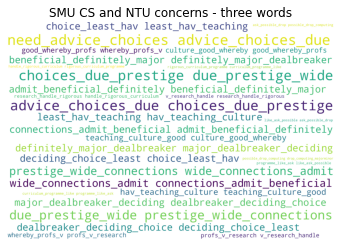

In [150]:
# # Top commmon body for SMU , NTU , BIZ , remove words

smu_ntu_body = only_ntu.iloc[:, [1]]

sentences = []
for sentence in smu_ntu_body["body"]:
    #sentences = []
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower() and 'biz' in sentence.lower():
        #print(sentence)
        sentences.append(sentence.lower())
        #print('--------------------------------')

sw.extend(['shed', 'light', 'able', 'ntu', 'vs','got', 'universities','two','heard','cs','nus', 'smu', 'comp', 'sci','exactly','x200b' , 'boil','nt', "n't",'rlly', 'u','hi', 'tat', 'much', 'sure', 'im', 'thank', 'really', "i'm", 'lol', 'bro', 'cmi', 
           'hahah' , 'one', 'well', 'hey', 'hey,' , 'also', 'would' , 'bat', 'right'])

single_word = token_fn(sentences, 1, sw)
wc_fn(single_word, 'SMU CS and NTU concerns - one word', 30)

double_word = token_fn(sentences, 2, sw)
wc_fn(double_word, 'SMU CS and NTU concerns - two words', 30)

triple_word = token_fn(sentences, 3, sw)
wc_fn(triple_word, 'SMU CS and NTU concerns - three words', 30)

In [152]:
#Finding for SMU, NTU, Law
only_ntu = df[df['title'].str.contains('NTU')]
qn_content =""
for line in only_ntu['title']:
    if 'ntu' in line.lower(): 
        qn_content += line.lower() + ' '    
        print(line)

[Uni] SMU CS vs NTU CS
[A levels] NTU CS /NTU CE and SMU IS/SMU CS
[Uni] NTU business and computing and SMU CS+BIZ
[Uni] SMU CS or NTU CE
[UNI] NUS CS VS NTU CN YANG SCHOLARS PROGRAMME + CS
[Uni] Computer Science NUS vs NTU vs SMU
[A levels] SMU IS vs SIT CS vs NTU CE vs SUTD ISTD
[UNI] should I transfer from NTU CS to SMU IS
[Uni] why did you choose NTU/NUS CS?
[Uni] What are the job prospects of a biz degree? Should I study biz at NUS or CS at NTU/SMU?
[Uni] I need some help in choosing uni course. NTU or SMU for CS? seniors please give me your input!!
[UNI]SMU Infosys compared to NUS/NTU
[Uni] Telegram Group Chats for Freshman in NUS, NTU, SMU, SUTD.
[Uni] Why NTU
[Uni] Is DDP worth it? NTU DDP VS SMU BIZ
